In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cancer-diagnosis/training_text
/kaggle/input/cancer-diagnosis/training_variants
/kaggle/input/cancertreatment/stage2_test_text.csv
/kaggle/input/cancertreatment/test_variants
/kaggle/input/cancertreatment/test_text
/kaggle/input/cancertreatment/stage_2_private_solution.csv
/kaggle/input/cancertreatment/stage2_sample_submission.csv
/kaggle/input/cancertreatment/stage2_test_variants.csv
/kaggle/input/cancertreatment/stage1_solution_filtered.csv


In [3]:
training_text = pd.read_csv("../input/cancer-diagnosis/training_text",sep="\|\|", header=None, skiprows=1, names=["ID","Text"])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [4]:
training_text.head(5)

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [5]:
training_text.shape

(3321, 2)

In [6]:
training_variants = pd.read_csv("../input/cancer-diagnosis/training_variants")

In [7]:
training_variants.head(5)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [8]:
training_variants.shape

(3321, 4)

In [9]:
#Merging variants and text on ID

In [10]:
training_merge = training_variants.merge(training_text,left_on="ID",right_on="ID")

In [11]:
training_merge.head(5)
#Now we have the data

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [12]:
training_merge.shape

(3321, 5)

In [13]:
test_text = pd.read_csv("../input/cancertreatment/stage2_test_text.csv",sep="\|\|", header=None, skiprows=1, names=["ID","Text"])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [14]:
test_text.shape

(986, 2)

In [15]:
training_variants = pd.read_csv("../input/cancertreatment/stage2_test_variants.csv")

In [16]:
training_variants.shape

(986, 3)

In [17]:
# Let's understand the type of values present in each column of our dataframe 'train_merge' dataframe.
training_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
Text         3316 non-null object
dtypes: int64(2), object(3)
memory usage: 155.7+ KB


In [18]:
training_merge.describe(include='all')

,ID,Gene,Variation,Class,Text
count,3321.000000,3321,3321,3321.000000,3316
unique,NaN,264,2996,NaN,1920
top,NaN,BRCA1,Truncating Mutations,NaN,The PTEN (phosphatase and tensin homolog) phos...
freq,NaN,264,93,NaN,53
mean,1660.000000,NaN,NaN,4.365854,NaN
std,958.834449,NaN,NaN,2.309781,NaN
min,0.000000,NaN,NaN,1.000000,NaN
25%,830.000000,NaN,NaN,2.000000,NaN
50%,1660.000000,NaN,NaN,4.000000,NaN
75%,2490.000000,NaN,NaN,7.000000,NaN


In [19]:
training_merge.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
Text         5
dtype: int64

In [20]:
training_merge.columns

Index(['ID', 'Gene', 'Variation', 'Class', 'Text'], dtype='object')

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

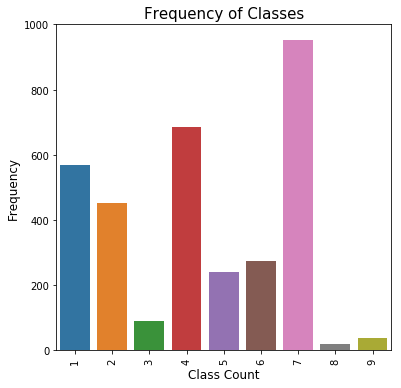

In [22]:
#Plot to see how classes are distributed
plt.figure(figsize=(6,6))
sns.countplot(x="Class", data=training_merge)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Class Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Classes", fontsize=15)
plt.show()

In [23]:
training_merge["Text_num_words"] = training_merge["Text"].apply(lambda x: len(str(x).split()) )
training_merge["Text_num_chars"] = training_merge["Text"].apply(lambda x: len(str(x)) )

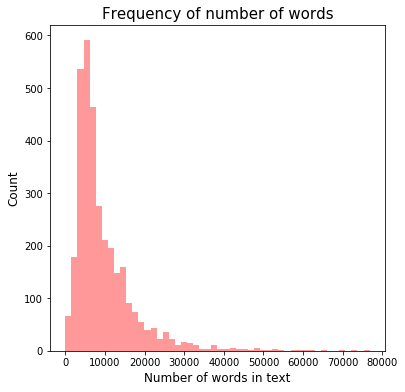

In [24]:
plt.figure(figsize=(6, 6))
sns.distplot(training_merge.Text_num_words.values, bins=50, kde=False, color='red')
plt.xlabel('Number of words in text', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title("Frequency of number of words", fontsize=15)
plt.show()

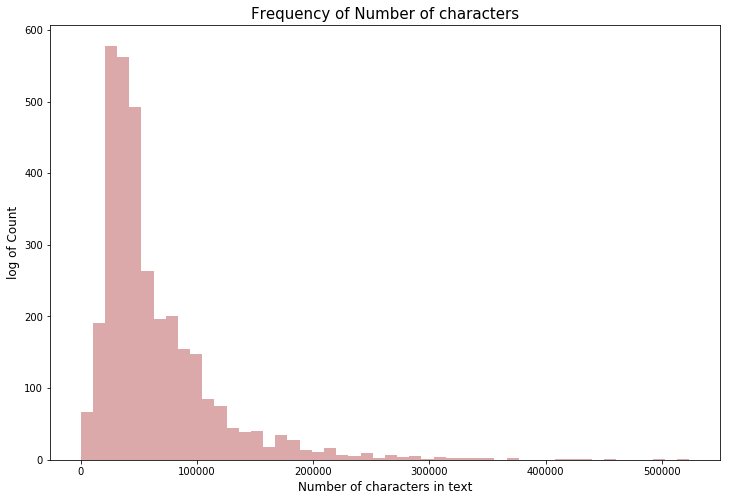

In [25]:
plt.figure(figsize=(12, 8))
sns.distplot(training_merge.Text_num_chars.values, bins=50, kde=False, color='brown')
plt.xlabel('Number of characters in text', fontsize=12)
plt.ylabel('log of Count', fontsize=12)
plt.title("Frequency of Number of characters", fontsize=15)
plt.show()

In [26]:
train_genes = training_merge.groupby('Gene')['Gene'].count()

for i in [2, 5, 10, 20, 50, 100, 300]:
    print('Genes that appear less than {} times: {}%'.format(i, round((train_genes < i).mean() * 100, 2)))

Genes that appear less than 2 times: 26.89%
Genes that appear less than 5 times: 53.03%
Genes that appear less than 10 times: 71.59%
Genes that appear less than 20 times: 82.95%
Genes that appear less than 50 times: 95.08%
Genes that appear less than 100 times: 98.11%
Genes that appear less than 300 times: 100.0%


In [27]:
training_merge['Variation'].describe()

count                     3321
unique                    2996
top       Truncating Mutations
freq                        93
Name: Variation, dtype: object

In [28]:
training_merge['Gene'].describe()

count      3321
unique      264
top       BRCA1
freq        264
Name: Gene, dtype: object

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


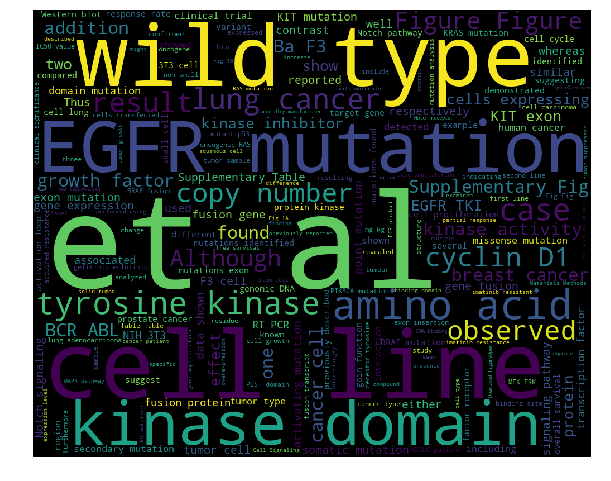

In [29]:
from wordcloud import WordCloud
cloud = WordCloud(width=1000, height=800).generate(" ".join(training_merge[training_merge.Class == 2]['Text']))
plt.figure(figsize=(10, 10))
plt.imshow(cloud)
plt.axis('off')
ax = plt.axes()

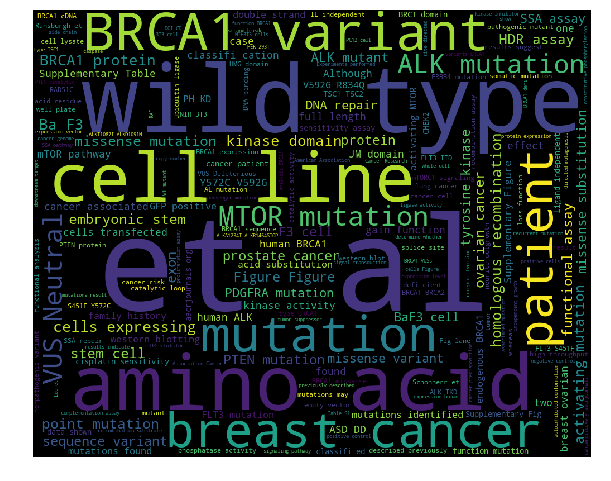

In [30]:
from wordcloud import WordCloud
cloud = WordCloud(width=1000, height=800).generate(" ".join(training_merge[training_merge.Class == 3]['Text']))
plt.figure(figsize=(10, 10))
plt.imshow(cloud)
plt.axis('off')
ax = plt.axes()

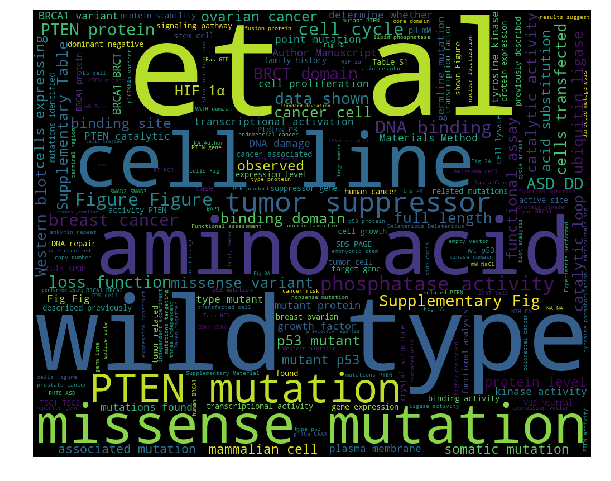

In [31]:
from wordcloud import WordCloud
cloud = WordCloud(width=1000, height=800).generate(" ".join(training_merge[training_merge.Class == 4]['Text']))
plt.figure(figsize=(10, 10))
plt.imshow(cloud)
plt.axis('off')
ax = plt.axes()


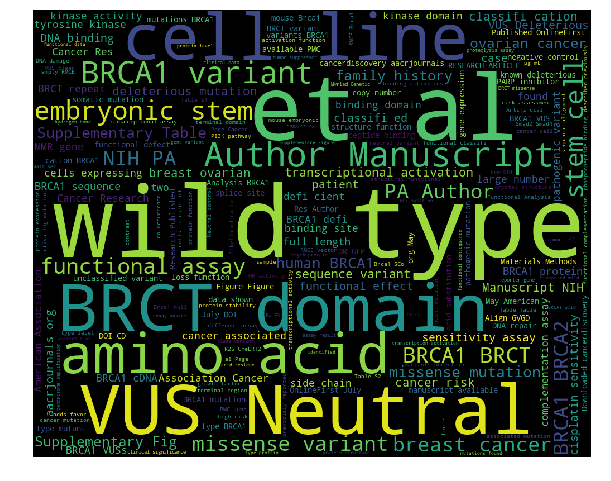

In [32]:
from wordcloud import WordCloud
cloud = WordCloud(width=1000, height=800).generate(" ".join(training_merge[training_merge.Class == 5]['Text']))
plt.figure(figsize=(10, 10))
plt.imshow(cloud)
plt.axis('off')
ax = plt.axes()

Text(0.5, 1.0, 'Class 2 Text Word Cloud')

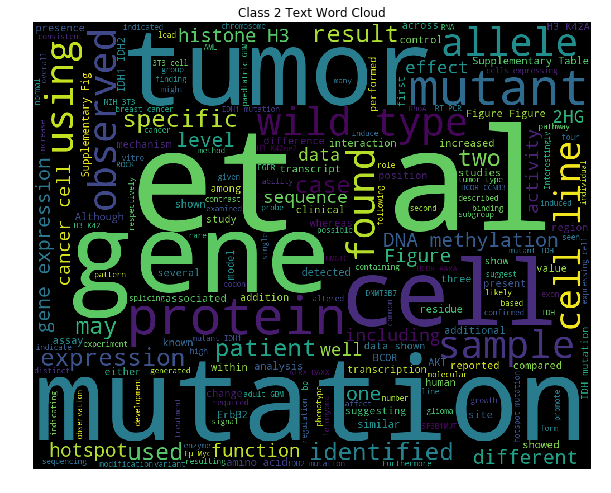

In [33]:
from wordcloud import WordCloud
cloud = WordCloud(width=1000, height=800).generate(" ".join(training_merge[training_merge.Class == 8]['Text']))
plt.figure(figsize=(10, 10))
plt.imshow(cloud)
plt.axis('off')
ax = plt.axes()
ax.set_title('Class 2 Text Word Cloud')

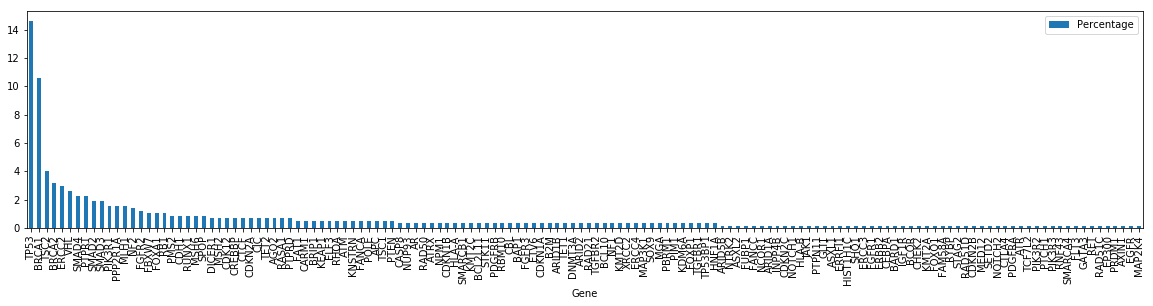

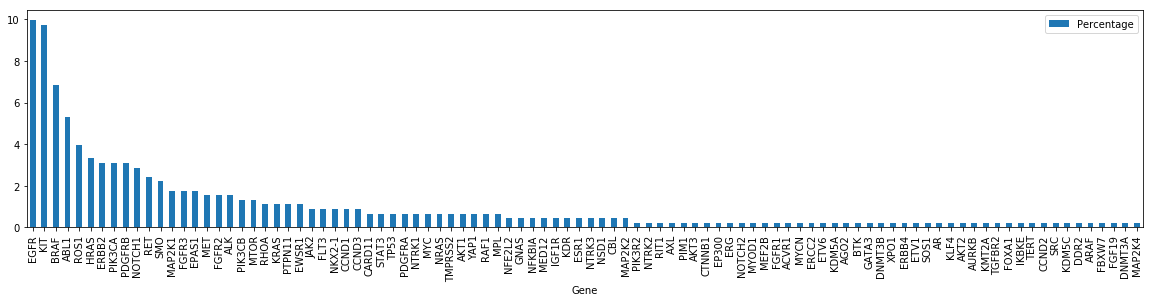

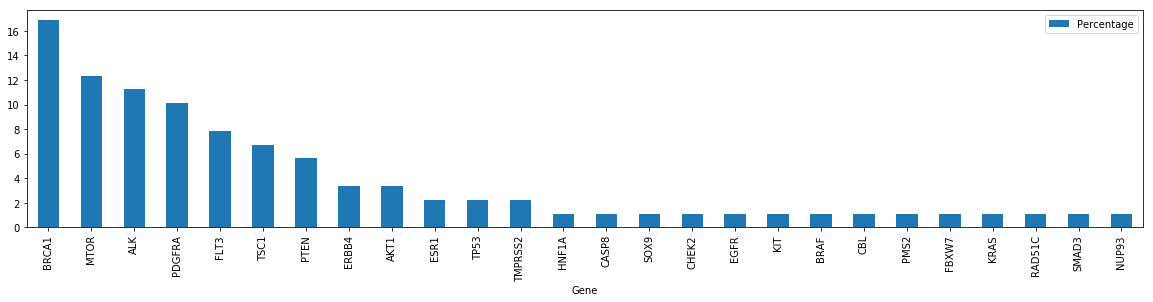

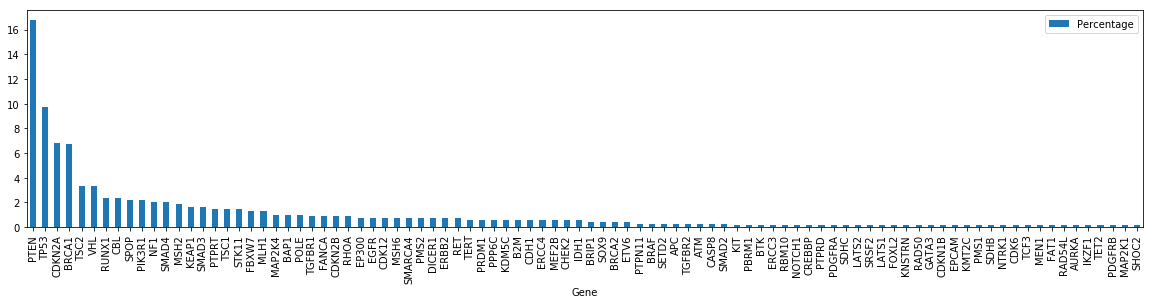

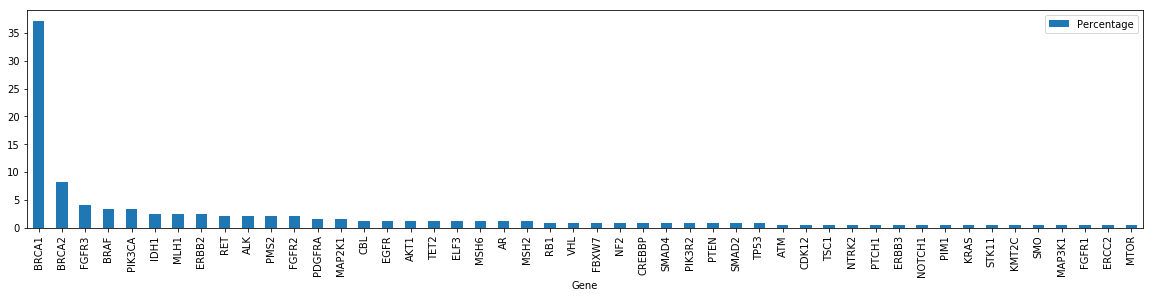

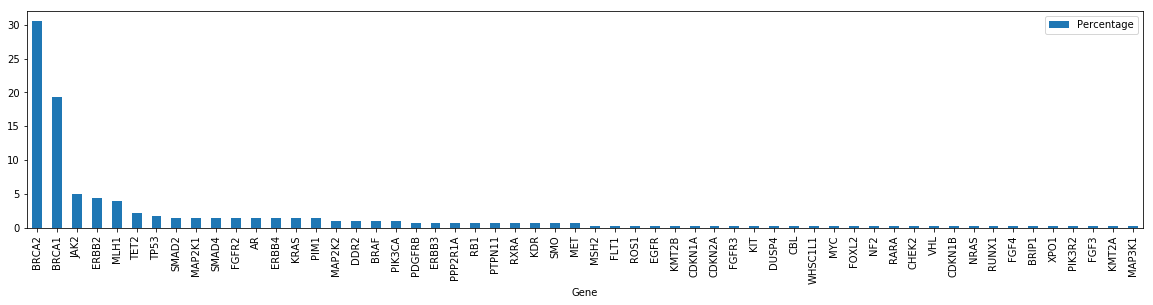

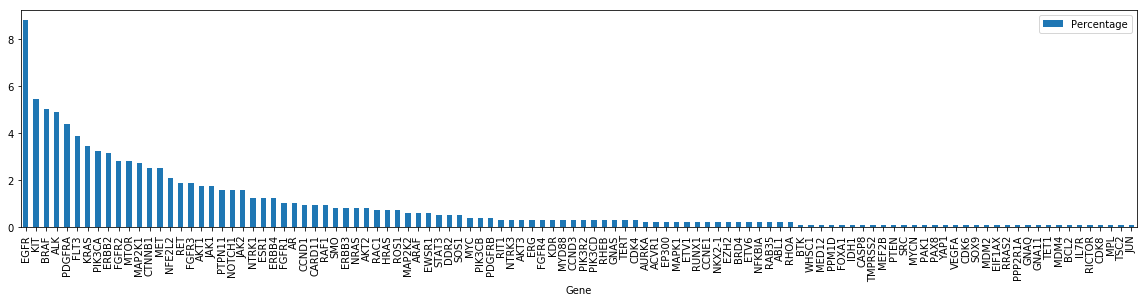

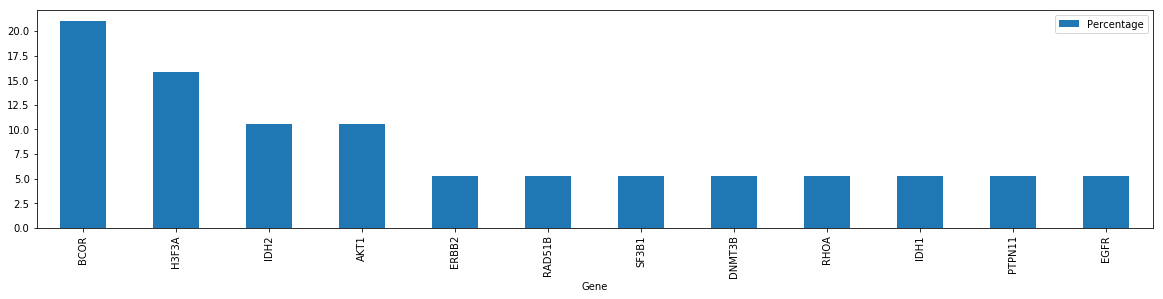

In [34]:
for i in range(1, 9):
    classs = training_merge.loc[training_merge['Class'] == i]

    cnt_genes = classs.Gene.value_counts().reset_index()
    cnt_genes.columns = ['Gene', 'Count']
    
    total = cnt_genes.Count.sum()
    
    cnt_genes['Percentage'] = (cnt_genes.Count/total)*100
    cnt_genes.plot(x='Gene', y='Percentage', kind='bar', figsize=(20,4))

In [35]:
cnt_genes.head()

,Gene,Count,Percentage
0,BCOR,4,21.052632
1,H3F3A,3,15.789474
2,IDH2,2,10.526316
3,AKT1,2,10.526316
4,ERBB2,1,5.263158


In [36]:
cnt_genes.describe

<bound method NDFrame.describe of       Gene  Count  Percentage
0     BCOR      4   21.052632
1    H3F3A      3   15.789474
2     IDH2      2   10.526316
3     AKT1      2   10.526316
4    ERBB2      1    5.263158
5   RAD51B      1    5.263158
6    SF3B1      1    5.263158
7   DNMT3B      1    5.263158
8     RHOA      1    5.263158
9     IDH1      1    5.263158
10  PTPN11      1    5.263158
11    EGFR      1    5.263158>

In [37]:
s = training_merge.Gene.value_counts().reset_index()
s.columns=['Gene', 'Count']

In [38]:
cnt = s.Count.value_counts().reset_index()
cnt.columns = ['Occurence', 'Count']
total = cnt.Count.sum()

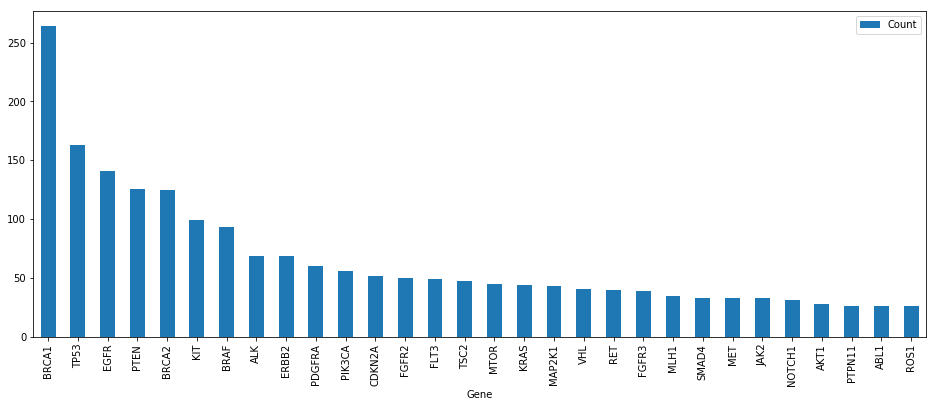

In [39]:
s.loc[s['Count'] > 25].plot(x='Gene', y='Count', kind='bar', figsize=(16, 6))

In [40]:
from collections import Counter
# Import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
# Import word_tokenize
from nltk.tokenize import word_tokenize
# Import stopwords
from nltk.corpus import stopwords
# Import string
import string
#Importing 

In [41]:
#Tokenzing-splitting up a larger body of text into smaller lines, words or even creating words 

In [42]:
#imputing gene row value to null data of text rows as for all other columns, Gene values are present in Text data
training_merge['Text'] = training_merge.apply(lambda row: row['Gene'] if pd.isnull(row['Text']) else row['Text'],axis=1)

In [43]:
training_merge.isnull().sum()

ID                0
Gene              0
Variation         0
Class             0
Text              0
Text_num_words    0
Text_num_chars    0
dtype: int64

In [44]:
#taking class column as dependent variable ie which needs to be find out from all other columns in our data
y=training_merge.Class

In [45]:
X=training_merge[["Text","Variation","Gene"]]

In [46]:
X.head()

,Text,Variation,Gene
0,Cyclin-dependent kinases (CDKs) regulate a var...,Truncating Mutations,FAM58A
1,Abstract Background Non-small cell lung canc...,W802*,CBL
2,Abstract Background Non-small cell lung canc...,Q249E,CBL
3,Recent evidence has demonstrated that acquired...,N454D,CBL
4,Oncogenic mutations in the monomeric Casitas B...,L399V,CBL


In [47]:
# Definig vectorizing object for Text column
vect_text= CountVectorizer(stop_words ='english')

#Defining vectorizing object for Variation column
vect_variation= CountVectorizer(stop_words ='english')

##Defining vectorizing object for Gene column
gene_variation= CountVectorizer(stop_words ='english')

In [48]:
#vectorizing  for Text column which gives the count of repeated words for each row
vect_text.fit(X["Text"])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [49]:
#vectorizing for Variation column  which gives the count of repeated words for each row
vect_variation.fit(X["Variation"])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [50]:
gene_variation.fit(X["Gene"])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [51]:
len(vect_text.vocabulary_)

155436

In [52]:
len(vect_variation.vocabulary_)

3018

In [53]:
vect_text.vocabulary_

{'cyclin': 46416,
 'dependent': 49831,
 'kinases': 84518,
 'cdks': 39059,
 'regulate': 122979,
 'variety': 149216,
 'fundamental': 63308,
 'cellular': 39396,
 'processes': 116246,
 'cdk10': 38984,
 'stands': 134564,
 'orphan': 106331,
 'activating': 21738,
 'identified': 77289,
 'kinase': 84487,
 'activity': 21828,
 'revealed': 124400,
 'previous': 115708,
 'work': 152130,
 'shown': 131283,
 'silencing': 131834,
 'increases': 79006,
 'ets2': 58046,
 'ets': 58044,
 'erythroblastosis': 57693,
 'virus': 149982,
 'e26': 54074,
 'oncogene': 105646,
 'homolog': 74768,
 'driven': 52980,
 'activation': 21744,
 'mapk': 92253,
 'pathway': 109370,
 'confers': 43377,
 'tamoxifen': 138590,
 'resistance': 123868,
 'breast': 33867,
 'cancer': 36529,
 'cells': 39240,
 'precise': 115237,
 'mechanisms': 93442,
 'modulates': 96818,
 'generally': 66518,
 'functions': 63287,
 'remain': 123237,
 'elusive': 56114,
 'demonstrate': 49617,
 'identifying': 77318,
 'product': 116305,
 'fam58a': 60058,
 'mutations

In [54]:
vect_variation.vocabulary_

{'truncating': 2650,
 'mutations': 1623,
 'w802': 2878,
 'q249e': 1913,
 'n454d': 1667,
 'l399v': 1440,
 'v391i': 2743,
 'v430m': 2747,
 'deletion': 483,
 'y371h': 2946,
 'c384r': 224,
 'p395a': 1813,
 'k382e': 1243,
 'r420q': 2179,
 'c381a': 222,
 'p428l': 1816,
 'd390y': 372,
 'q367p': 1922,
 'm374v': 1593,
 'y371s': 2947,
 'h94y': 1097,
 'c396r': 225,
 'g375p': 918,
 's376f': 2429,
 'p417a': 1815,
 'h398y': 1060,
 's2g': 2409,
 'y846c': 3005,
 'c228t': 201,
 'h412y': 1062,
 'h876q': 1092,
 'promoter': 1880,
 'p704s': 1851,
 'amplification': 155,
 'c250t': 210,
 'g1809r': 866,
 'g1809k': 865,
 'd1709e': 317,
 'd1709a': 316,
 'e1705a': 528,
 'd1810a': 329,
 'e1705k': 529,
 't1365m': 2529,
 'v648g': 2789,
 't844m': 2628,
 'a707t': 122,
 'hypermethylation': 1100,
 'r1343l': 2004,
 'a209t': 72,
 'y280h': 2933,
 'd927g': 473,
 'n510k': 1674,
 'f248s': 742,
 'l708p': 1499,
 'v995m': 2828,
 'y412f': 2954,
 'f74s': 777,
 'r1040l': 1964,
 'r453c': 2183,
 'r1209w': 1986,
 'a1022e': 21,
 'q984k

In [55]:
gene_variation.vocabulary_

{'fam58a': 85,
 'cbl': 39,
 'shoc2': 227,
 'tert': 245,
 'dicer1': 62,
 'ptprt': 198,
 'rheb': 213,
 'shq1': 228,
 'ccnd2': 41,
 'rad50': 202,
 'ccnd3': 42,
 'rit1': 216,
 'ccne1': 43,
 'rybp': 222,
 'tgfbr1': 248,
 'tgfbr2': 249,
 'msh6': 154,
 'kmt2d': 134,
 'lats1': 137,
 'pbrm1': 177,
 'sf3b1': 226,
 'lats2': 138,
 'egfr': 66,
 'nkx2': 165,
 'eif1ax': 67,
 'arid2': 12,
 'brd4': 33,
 'hist1h1c': 110,
 'errfi1': 79,
 'chek2': 55,
 'pak1': 175,
 'tmprss2': 250,
 'h3f3a': 109,
 'elf3': 68,
 'ros1': 218,
 'asxl2': 15,
 'cdh1': 44,
 'epcam': 71,
 'ep300': 69,
 'epas1': 70,
 'tp53': 251,
 'tp53bp1': 252,
 'smad2': 229,
 'smad3': 230,
 'smad4': 231,
 'cdk4': 46,
 'aurkb': 20,
 'cdk6': 47,
 'fbxw7': 89,
 'cdk8': 48,
 'cdkn1a': 49,
 'cdkn1b': 50,
 'cdkn2a': 51,
 'cdkn2b': 52,
 'cdkn2c': 53,
 'asxl1': 14,
 'erbb2': 72,
 'erbb3': 73,
 'erbb4': 74,
 'ercc2': 75,
 'brip1': 34,
 'ercc3': 76,
 'ercc4': 77,
 'abl1': 0,
 'cebpa': 54,
 'erg': 78,
 'hla': 111,
 'pdgfra': 178,
 'pdgfrb': 179,
 'rbm10':

In [56]:
#transforming count of Variation words in to matrix
variation_tranform_train=vect_variation.transform(X["Variation"])

In [57]:
#transforming count of Text words in to matrix
text_transformed_train= vect_text.transform(X["Text"])

In [58]:
#transforming count of gene words in to matrix
gene_transformed_train= gene_variation.transform(X["Gene"])

In [59]:
#merging train data of two Matrix horixzontally to train the model
import scipy.sparse as sp
X_final = sp.hstack((variation_tranform_train,text_transformed_train,gene_transformed_train))

In [60]:
X_final.shape

(3321, 158717)

In [61]:
y.shape

(3321,)

In [62]:
# splitting into test and train
from sklearn.model_selection  import train_test_split
from imblearn.over_sampling import SMOTE
X_train, X_test, y_train, y_test = train_test_split(X_final, y, random_state=1)

In [63]:
print(X_train.shape)

(2490, 158717)


In [64]:
print(y_train.shape)

(2490,)


In [65]:
print(X_test.shape)

(831, 158717)


In [66]:
print(y_test.shape)

(831,)


In [67]:
# Let's run Linear SVM model using the selected variables
from sklearn import metrics
from sklearn import svm
from sklearn.metrics import classification_report
svc_model=svm.LinearSVC()
svc_model.fit(X_train,y_train)

#predicting the Test data using our trained Linear SVM model
y_pred_class = svc_model.predict(X_test)

print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           1       0.57      0.50      0.53       142
           2       0.58      0.51      0.55       117
           3       0.15      0.11      0.13        27
           4       0.66      0.61      0.63       170
           5       0.24      0.44      0.31        50
           6       0.64      0.72      0.68        61
           7       0.68      0.70      0.69       250
           8       1.00      0.60      0.75         5
           9       1.00      0.67      0.80         9

    accuracy                           0.59       831
   macro avg       0.61      0.54      0.56       831
weighted avg       0.60      0.59      0.59       831



/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [68]:
for i in range(1,9):
    print("Before SMOTE, counts of label {}: {}".format(i,sum(y_train == i))) 
 
# apply near miss 
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2) 
  
X_train_miss, y_train_miss = sm.fit_sample(X_train, y_train.ravel()) 
  
print('After SMOTE, the shape of train_X:{}'.format(X_train_miss.shape)) 
print('After SMOTE, the shape of train_y: {} \n'.format(y_train_miss.shape)) 

for i in range(1,9):
    print("After SMOTE, counts of label {}: {}".format(i,sum(y_train_miss == i))) 

Before SMOTE, counts of label 1: 426
Before SMOTE, counts of label 2: 335
Before SMOTE, counts of label 3: 62
Before SMOTE, counts of label 4: 516
Before SMOTE, counts of label 5: 192
Before SMOTE, counts of label 6: 214
Before SMOTE, counts of label 7: 703
Before SMOTE, counts of label 8: 14
After SMOTE, the shape of train_X:(6327, 158717)
After SMOTE, the shape of train_y: (6327,) 

After SMOTE, counts of label 1: 703
After SMOTE, counts of label 2: 703
After SMOTE, counts of label 3: 703
After SMOTE, counts of label 4: 703
After SMOTE, counts of label 5: 703
After SMOTE, counts of label 6: 703
After SMOTE, counts of label 7: 703
After SMOTE, counts of label 8: 703


In [69]:
# Let's run Linear SVM model using the selected variables
from sklearn import metrics
from sklearn import svm
from sklearn.metrics import classification_report
svc_model=svm.LinearSVC()
svc_model.fit(X_train_miss,y_train_miss)

#predicting the Test data using our trained Linear SVM model
y_pred_class = svc_model.predict(X_test)
print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           1       0.51      0.56      0.53       142
           2       0.56      0.49      0.52       117
           3       0.46      0.59      0.52        27
           4       0.64      0.64      0.64       170
           5       0.17      0.18      0.17        50
           6       0.57      0.72      0.64        61
           7       0.73      0.66      0.69       250
           8       0.50      0.40      0.44         5
           9       0.75      0.67      0.71         9

    accuracy                           0.59       831
   macro avg       0.54      0.55      0.54       831
weighted avg       0.59      0.59      0.59       831



In [70]:
#Hyperparameter tuning for Random Forest

In [71]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
val_log_loss_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42)
        clf.fit(X_train_miss, y_train_miss)
        calib_clf = CalibratedClassifierCV(clf, method="sigmoid")
        calib_clf.fit(X_train_miss, y_train_miss)
        calib_clf_probs = calib_clf.predict_proba(X_test)
        val_log_loss_array.append(log_loss(y_test,calib_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(y_test,calib_clf_probs)) 

best_alpha = np.argmin(val_log_loss_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42)
clf.fit(X_train_miss,y_train_miss)
calib_clf = CalibratedClassifierCV(clf, method="sigmoid")
calib_clf.fit(X_train_miss, y_train_miss)

for n_estimators = 100 and max depth =  5


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log Loss : 1.3308428149916165
for n_estimators = 100 and max depth =  10


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log Loss : 1.190204921483005
for n_estimators = 200 and max depth =  5


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log Loss : 1.3183661056361726
for n_estimators = 200 and max depth =  10


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log Loss : 1.1766863156341336
for n_estimators = 500 and max depth =  5


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log Loss : 1.3056642155776055
for n_estimators = 500 and max depth =  10


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log Loss : 1.1649608700627485
for n_estimators = 1000 and max depth =  5


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log Loss : 1.3013296798445055
for n_estimators = 1000 and max depth =  10


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log Loss : 1.1662572075551436
for n_estimators = 2000 and max depth =  5


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log Loss : 1.2992000550901328
for n_estimators = 2000 and max depth =  10


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Log Loss : 1.1658952091152448


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True,
                                                             class_weight=None,
                                                             criterion='gini',
                                                             max_depth=10,
                                                             max_features='auto',
                                                             max_leaf_nodes=None,
                                                             min_impurity_decrease=0.0,
                                                             min_impurity_split=None,
                                                             min_samples_leaf=1,
                                                             min_samples_split=2,
                                                             min_weight_fraction_leaf=0.0,
                                                             n_estimators=500,
                  

 **Using TF-IDF**

In [72]:
tf=TfidfVectorizer()
text_tf= tf.fit_transform(training_merge['Text'])

In [73]:
text_tf

<3321x155732 sparse matrix of type '<class 'numpy.float64'>'
	with 5620942 stored elements in Compressed Sparse Row format>

In [74]:
X_train, X_test, y_train, y_test = train_test_split(
    text_tf, training_merge['Class'], test_size=0.3, random_state=123)

In [75]:
X_train.shape

(2324, 155732)

In [76]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report 
# Model Generation Using Multinomial Naive Bayes
clf = MultinomialNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))
print(classification_report(y_test,predicted))

MultinomialNB Accuracy: 0.40220661985957873
              precision    recall  f1-score   support

           1       0.67      0.19      0.29       155
           2       0.00      0.00      0.00       145
           3       0.00      0.00      0.00        20
           4       0.57      0.43      0.49       212
           5       0.00      0.00      0.00        74
           6       0.00      0.00      0.00        92
           7       0.35      1.00      0.52       281
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00        12

    accuracy                           0.40       997
   macro avg       0.18      0.18      0.14       997
weighted avg       0.33      0.40      0.30       997



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [77]:
#Trying to handle imbalanced data

In [78]:
#SMOTE

In [79]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report 
# Model Generation Using Multinomial Naive Bayes
clf = MultinomialNB().fit(X_train_miss, y_train_miss)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))
print(classification_report(y_test,predicted))

ValueError: dimension mismatch

In [80]:
#USING SMOTE

In [81]:
for i in range(1,9):
    print("Before SMOTE, counts of label {}: {}".format(i,sum(y_train == i))) 
 
# apply near miss 
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2) 
  
X_train_miss, y_train_miss = sm.fit_sample(X_train, y_train.ravel()) 
  
print('After SMOTE, the shape of train_X:{}'.format(X_train_miss.shape)) 
print('After SMOTE, the shape of train_y: {} \n'.format(y_train_miss.shape)) 

for i in range(1,9):
    print("After SMOTE, counts of label {}: {}".format(i,sum(y_train_miss == i))) 

Before SMOTE, counts of label 1: 413
Before SMOTE, counts of label 2: 307
Before SMOTE, counts of label 3: 69
Before SMOTE, counts of label 4: 474
Before SMOTE, counts of label 5: 168
Before SMOTE, counts of label 6: 183
Before SMOTE, counts of label 7: 672
Before SMOTE, counts of label 8: 13
After SMOTE, the shape of train_X:(6048, 155732)
After SMOTE, the shape of train_y: (6048,) 

After SMOTE, counts of label 1: 672
After SMOTE, counts of label 2: 672
After SMOTE, counts of label 3: 672
After SMOTE, counts of label 4: 672
After SMOTE, counts of label 5: 672
After SMOTE, counts of label 6: 672
After SMOTE, counts of label 7: 672
After SMOTE, counts of label 8: 672


In [82]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report 
# Model Generation Using Multinomial Naive Bayes
clf = MultinomialNB().fit(X_train_miss, y_train_miss)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))
print(classification_report(y_test,predicted))

MultinomialNB Accuracy: 0.5075225677031093
              precision    recall  f1-score   support

           1       0.53      0.44      0.48       155
           2       0.40      0.68      0.51       145
           3       0.15      0.45      0.23        20
           4       0.74      0.48      0.58       212
           5       0.35      0.47      0.40        74
           6       0.68      0.59      0.63        92
           7       0.65      0.47      0.54       281
           8       0.04      0.17      0.06         6
           9       0.47      0.75      0.58        12

    accuracy                           0.51       997
   macro avg       0.45      0.50      0.44       997
weighted avg       0.58      0.51      0.52       997



In [83]:
#ACCURACY DOES BETTER WITH SMOTE SO WE WILL USE SMOTE

In [84]:
# Let's run Linear SVM model using the selected variables
from sklearn import metrics
from sklearn import svm
from sklearn.metrics import classification_report
svc_model=svm.LinearSVC()
svc_model.fit(X_train_miss,y_train_miss)

#predicting the Test data using our trained Linear SVM model
y_pred_class = svc_model.predict(X_test)

print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           1       0.55      0.55      0.55       155
           2       0.53      0.54      0.53       145
           3       0.21      0.45      0.29        20
           4       0.74      0.62      0.68       212
           5       0.40      0.54      0.46        74
           6       0.74      0.60      0.66        92
           7       0.67      0.67      0.67       281
           8       0.25      0.17      0.20         6
           9       0.60      0.75      0.67        12

    accuracy                           0.60       997
   macro avg       0.52      0.54      0.52       997
weighted avg       0.62      0.60      0.61       997

